# SIT744 Practical 8: ConvNet Visualisation
 

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Visualizing what convnets learn](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)


In the last lecture, we introduced three ways to visualise a trained ConvNet. In this practical, we will practice generating such visualisations using the cat-vs-dog example.








In [66]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

TRAIN_DS_SIZE = 2000
VALID_DS_SIZE = 1000
TEST_DS_SIZE = 1000

(cat_dog_train, cat_dog_valid, cat_dog_test), info = tfds.load('cats_vs_dogs', 
                                                               split=[f'train[:{TRAIN_DS_SIZE}]', 
                                                                      f'train[{TRAIN_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE}]', 
                                                                      f'train[{TRAIN_DS_SIZE + VALID_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE + TEST_DS_SIZE}]'],
                                                               with_info=True,
                                                               as_supervised=True)

## Task 1 Visualizing intermediate activations

We will first retrain a ConvNet for the dataset. 

In [67]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


IMAGE_SIZE = 150
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

TRAIN_BATCH_SIZE = 20
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()



def make_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

  return model

model = make_model()  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [68]:
%%time 

history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=50
      )

model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 9s 79ms/step - loss: 0.6924 - acc: 0.5371 - val_loss: 0.6885 - val_acc: 0.5050
Epoch 2/30
100/100 [==============================] - 4s 44ms/step - loss: 0.6771 - acc: 0.5632 - val_loss: 0.6545 - val_acc: 0.6670
Epoch 3/30
100/100 [==============================] - 4s 44ms/step - loss: 0.6436 - acc: 0.6286 - val_loss: 0.6204 - val_acc: 0.6790
Epoch 4/30
100/100 [==============================] - 4s 44ms/step - loss: 0.6040 - acc: 0.6880 - val_loss: 0.5978 - val_acc: 0.6850
Epoch 5/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5718 - acc: 0.7068 - val_loss: 0.5828 - val_acc: 0.6900
Epoch 6/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5449 - acc: 0.7298 - val_loss: 0.5705 - val_acc: 0.6950
Epoch 7/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5202 - acc: 0.7445 - val_loss: 0.5614 - val_acc: 0.7040
Epoch 8/30
100/100 [==============================] - 4s 44ms/step - 

The model isn't perfect, as shown below.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


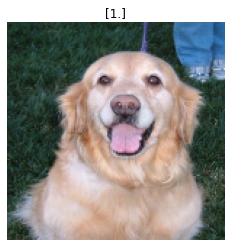

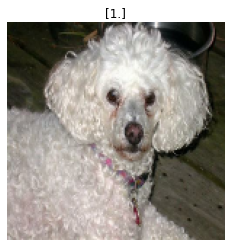

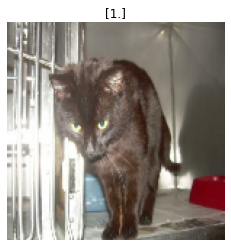

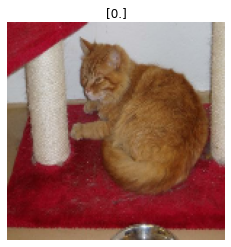

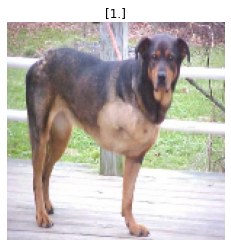

In [69]:
## Show the image and label
import matplotlib.pyplot as plt
import numpy as np

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

for images, labels in cat_dog_test.map(pre_process_image).batch(1).take(5):
  predictions = model.predict(images) 
  for image, prediction in zip(images, predictions):
    show(image, np.round(prediction))

Now we can visualise the model representations. First, let's define a multi-output network. The new network shares the same input layer, but outputs intermediate layers.

The input layer can be accessed as below.

In [70]:
model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_4_input')>

All the other layers can be accessed as follows.

In [71]:
model.layers

All the layers have been named by Keras.

In [72]:
[layer.name for layer in model.layers]

['conv2d_4',
 'max_pooling2d_4',
 'conv2d_5',
 'max_pooling2d_5',
 'conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7',
 'flatten_1',
 'dense_2',
 'dense_3']

We are interested in only convolutional layers and pooling layers.

In [73]:
# Extracts the outputs of the layers where '2d' is in the layer name :
layer_outputs = [layer.output for layer in model.layers if '2d' in layer.name]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Let's first look at the dog image correctly classified above.

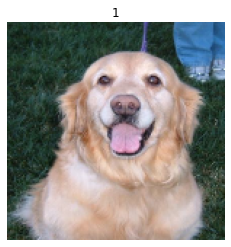

In [74]:
for image, label in cat_dog_test.map(pre_process_image).take(1):
  show(image, label.numpy())

Generate the intermediate activations.

In [75]:
for image, label in cat_dog_test.map(pre_process_image).take(1).batch(1):
  # This will return a list of 5 Numpy arrays:
  # one array per layer activation
  activations = activation_model.predict(image)

Each output is a feature map, which contains a stack of 2D features.

(1, 148, 148, 32)


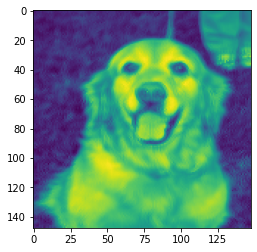

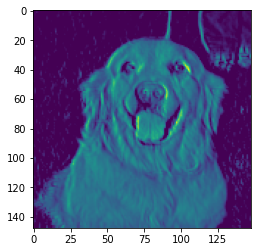

(1, 7, 7, 128)


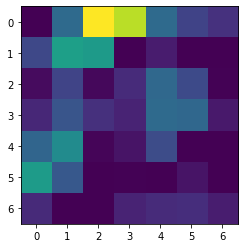

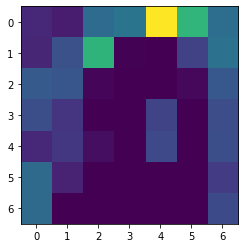

In [76]:
print(activations[0].shape) # The first feature map

plt.imshow(activations[0][0,:,:,0])
plt.show()
plt.imshow(activations[0][0,:,:,31])
plt.show()

print(activations[7].shape) # The last feature map
plt.imshow(activations[7][0,:,:,0])
plt.show()
plt.imshow(activations[7][0,:,:,127])
plt.show()

The following code shows all 8 feature maps.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


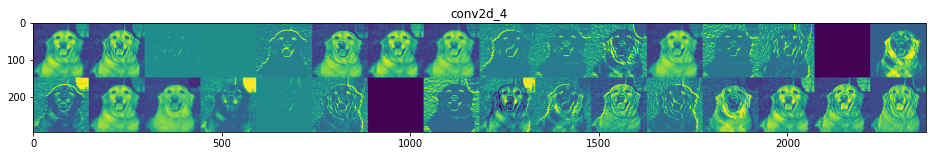

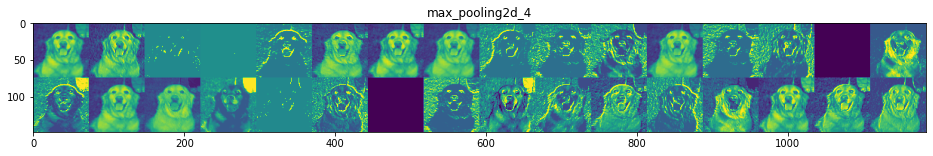

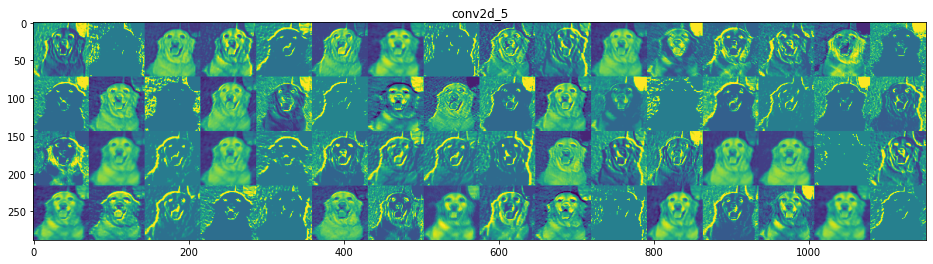

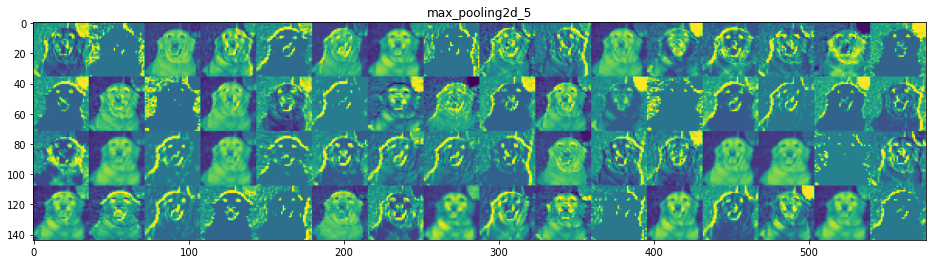

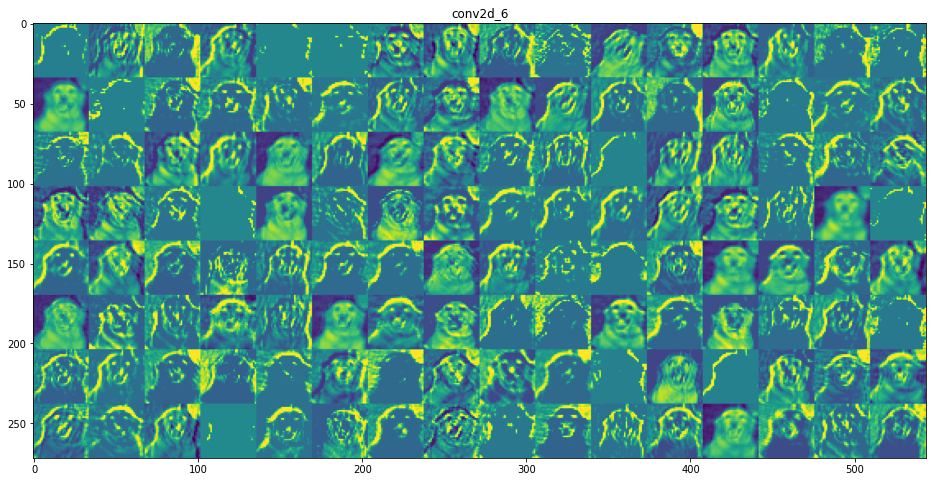

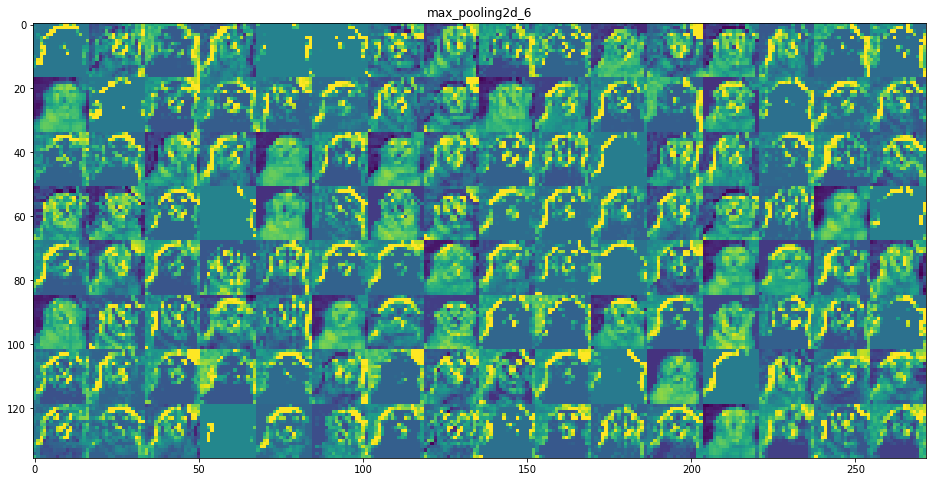

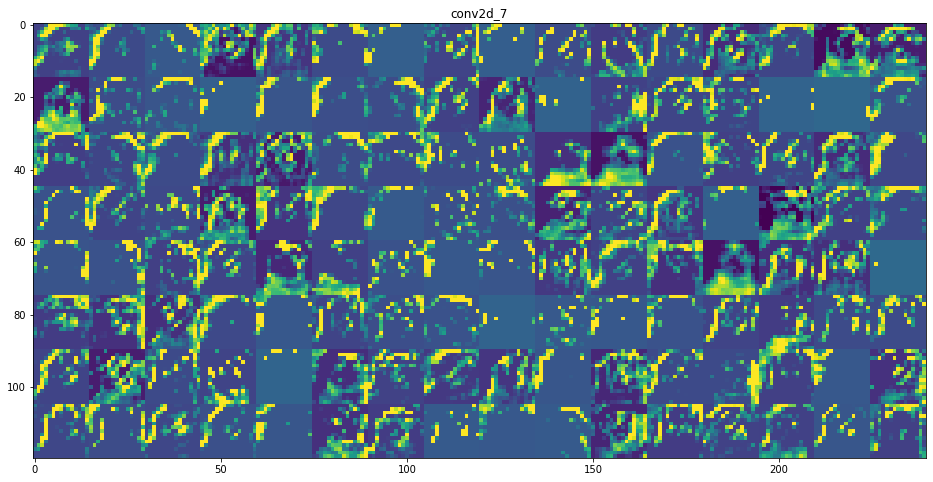

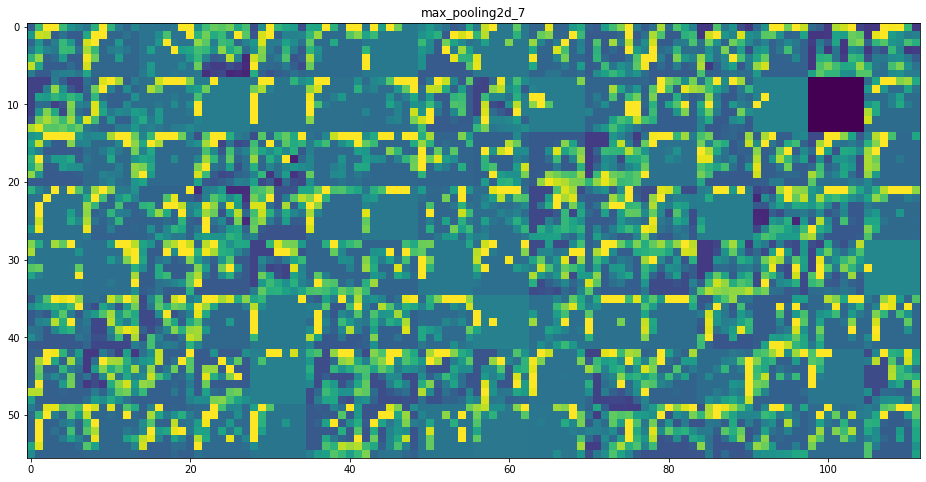

In [77]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers if '2d' in layer.name]

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()


**exercise** Feed in some other images in the test dataset. And visualise the feature maps. Do you see any difference between the activations for cat images and those for dog images?

## Task 2 Visualizing filters via gradient ascent

This type of visualisation does not depend on the input image. Given a filter (layer+channel), we aggregate the activation to produce the loss function. Note here we actually want to maximise the "loss".

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [167]:
model.layers[6].name

'conv2d_7'

In [175]:
from keras import backend as K

## select the target filter to visualise
layer_name = model.layers[6].name
filter_index = 0

layer_output = model.get_layer(layer_name).output

# Create a connection between the input and the target layer
submodel = models.Model([model.inputs[0]], [layer_output])

We start from a gray image with some noise and try to morph it into an image that maximally activate the target filter.

In [176]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
input_img_tensor = tf.Variable(tf.cast(input_img_data, tf.float32))

This image will activate the filter.

In [177]:
# Do the forward computation
with tf.GradientTape() as tape:
  outputs = submodel(input_img_tensor)
  activation_value = tf.reduce_mean(outputs[:, :, :, filter_index]) # Reduce the activation to one number

grads = tape.gradient(activation_value, input_img_tensor)

Here the input will be the parameters to tune. Like before, we normalise the gradients.

In [178]:
normalized_grads = \
    grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5) # Add a small costant at the end to avoid divisions by 0


step_size = 1.0 # step size of gradient ascent

input_img_tensor.assign_add(normalized_grads * step_size)

<tf.Variable 'UnreadVariable' shape=(1, 150, 150, 3) dtype=float32, numpy=
array([[[[140.33621, 134.55539, 136.98802],
         [129.45341, 142.99107, 137.61983],
         [134.24457, 135.99103, 132.19608],
         ...,
         [140.17831, 134.59993, 135.28935],
         [147.42407, 142.64268, 136.19604],
         [128.95795, 144.372  , 141.97546]],

        [[141.1753 , 138.2559 , 138.05894],
         [142.72585, 137.65901, 132.48932],
         [137.31946, 141.70148, 139.70697],
         ...,
         [131.89888, 141.8552 , 129.08983],
         [130.88498, 141.73665, 146.29703],
         [141.71112, 143.08066, 146.58398]],

        [[128.19385, 136.52744, 138.89824],
         [128.26263, 133.64696, 140.74863],
         [135.78072, 147.36916, 147.0737 ],
         ...,
         [141.47487, 145.30122, 139.42549],
         [129.7468 , 131.87881, 129.08505],
         [135.92673, 139.72505, 132.76967]],

        ...,

        [[131.37144, 138.14091, 128.25267],
         [133.04568, 132.56

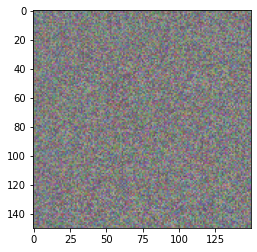

In [179]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

plt.imshow(deprocess_image(input_img_tensor[0].numpy() ))
plt.show()

Not much to see here. But let's repeat this 400 times, continuing gradient ascent from this image.

In [180]:
for _ in range(400):
  with tf.GradientTape() as tape:
    outputs = submodel(input_img_tensor)
    loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])

  grads = tape.gradient(loss_value, input_img_tensor)
  normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
  input_img_tensor.assign_add(normalized_grads * step_size)


After 400 steps, the random image becomes an image that will result in high activation at the target filter.

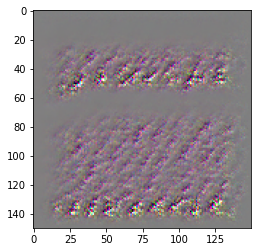

In [181]:
plt.imshow(deprocess_image(input_img_tensor[0].numpy()))
plt.show()

Because we trained a relatively shallow model with a relatively small training dataset, the filters are not unnecessarily very interpretable.

**exercise** 

1. Retrain your model with data augmentation, and then visualise the filter banks in the retrained model.
2. Load a model pretrained with ImageNet and visualise the filters in the model.

## Task 3 Class Activation Map (CAM) visualization



Class Activation Map (CAM) is used to generate a heatmap highlighting the part of the input image influencing the model's classification decision. We will base the heatmap on the last layer feature map. With the risk of over-simplification, you may consider the method is to look for regions that are most positively correlated with the prediction.

In [189]:
last_conv_layer = model.layers[6]
layer_output = last_conv_layer.output

# Create a connection between the input and the target layer
submodel = models.Model(model.inputs, [layer_output, model.output])

We have a binary output node, with 1 for 'dog' and 0 for 'cat'. We can define the gradients of the output node (the probability of 'dog') over the feature map.

In [252]:
for image, label in cat_dog_test.map(pre_process_image).take(1).batch(1):
  with tf.GradientTape() as tape:
    conv_output, predictions = submodel(image)
    prediction = predictions[0]

grads = tape.gradient(prediction, conv_output)[0]

In [253]:
grads.shape

TensorShape([15, 15, 128])

For each feature, we need only one number as the channel weight.

In [255]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
pooled_grads.shape

TensorShape([128])

Next, we use the weights to aggregate the activations of different features.  

In [256]:
cam = tf.multiply(conv_output[0], pooled_grads)

heatmap = np.mean(cam, axis=-1)

It can be normalised between 0 and 1.


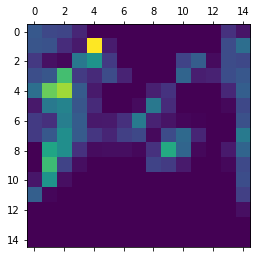

In [257]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we superimpose the heatmap over the original image.

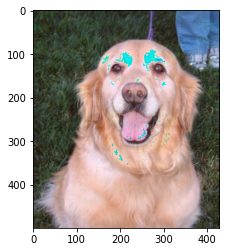

In [266]:
import cv2

img, _ = next(iter(cat_dog_test)) #reload the image, without normalisation

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.1 + img
plt.imshow(superimposed_img)

The visualisation seems to suggest that the areas surrounding the eyes and the tongue led to the image being classified as dog.

**exercise** Try to produce a CAM heatmap visualisation with the pretrained VGG16 model downloaded from `keras.applications`.

## Additional resources

- [tf-explain](https://github.com/sicara/tf-explain)